<a href="https://colab.research.google.com/github/nanpolend/365E5/blob/master/%E5%B0%8B%E6%89%BE%E9%A1%9E%E5%9C%B0%E6%98%9F%E7%90%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

正在從 NASA Exoplanet Archive 取得最新資料...
資料欄位： ['objectid', 'pl_name', 'pl_letter', 'hostid', 'hostname', 'hd_name', 'hip_name', 'tic_id', 'disc_pubdate', 'disc_year', 'disc_method', 'discoverymethod', 'disc_locale', 'disc_facility', 'disc_instrument', 'disc_telescope', 'disc_refname', 'ra', 'raerr1', 'raerr2', 'rasymerr', 'rastr', 'ra_solnid', 'ra_reflink', 'dec', 'decerr1', 'decerr2', 'decsymerr', 'decstr', 'dec_solnid', 'dec_reflink', 'glon', 'glonerr1', 'glonerr2', 'glonsymerr', 'glonstr', 'glon_solnid', 'glon_reflink', 'glat', 'glaterr1', 'glaterr2', 'glatsymerr', 'glatstr', 'glat_solnid', 'glat_reflink', 'elon', 'elonerr1', 'elonerr2', 'elonsymerr', 'elonstr', 'elon_solnid', 'elon_reflink', 'elat', 'elaterr1', 'elaterr2', 'elatsymerr', 'elat_solnid', 'elat_reflink', 'elatstr', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbpersymerr', 'pl_orbperlim', 'pl_orbperstr', 'pl_orbperformat', 'pl_orbper_solnid', 'pl_orbper_reflink', 'pl_orblpererr1', 'pl_orblper', 'pl_orblpererr2', 'p

<ipython-input-4-9ebb3b4a5f6e>:30: RuntimeWarning: invalid value encountered in sqrt
  inner = 0.95 * np.sqrt(star_lum)
<ipython-input-4-9ebb3b4a5f6e>:31: RuntimeWarning: invalid value encountered in sqrt
  outer = 1.37 * np.sqrt(star_lum)
<ipython-input-4-9ebb3b4a5f6e>:27: RuntimeWarning: invalid value encountered in sqrt
  inner = 0.75 * np.sqrt(star_lum)
<ipython-input-4-9ebb3b4a5f6e>:28: RuntimeWarning: invalid value encountered in sqrt
  outer = 1.77 * np.sqrt(star_lum)
<ipython-input-4-9ebb3b4a5f6e>:30: RuntimeWarning: invalid value encountered in sqrt
  inner = 0.95 * np.sqrt(star_lum)
<ipython-input-4-9ebb3b4a5f6e>:31: RuntimeWarning: invalid value encountered in sqrt
  outer = 1.37 * np.sqrt(star_lum)


發現 5 顆潛在類地行星
最佳候選名單：
            name  radius  orbital_period  insolation star_type  distance_pc
1  Kepler-1599 b    1.62      122.363553    1.043593         G     1328.200
2   Kepler-132 e    1.18      110.286937    1.021308         F      349.549
0   Kepler-204 c    1.79       25.660593    1.003089         G      686.723
3   Kepler-200 c    1.59       10.222157    0.933132         G      665.912
4   Kepler-131 c    0.84       25.516900    0.751513         G      228.678


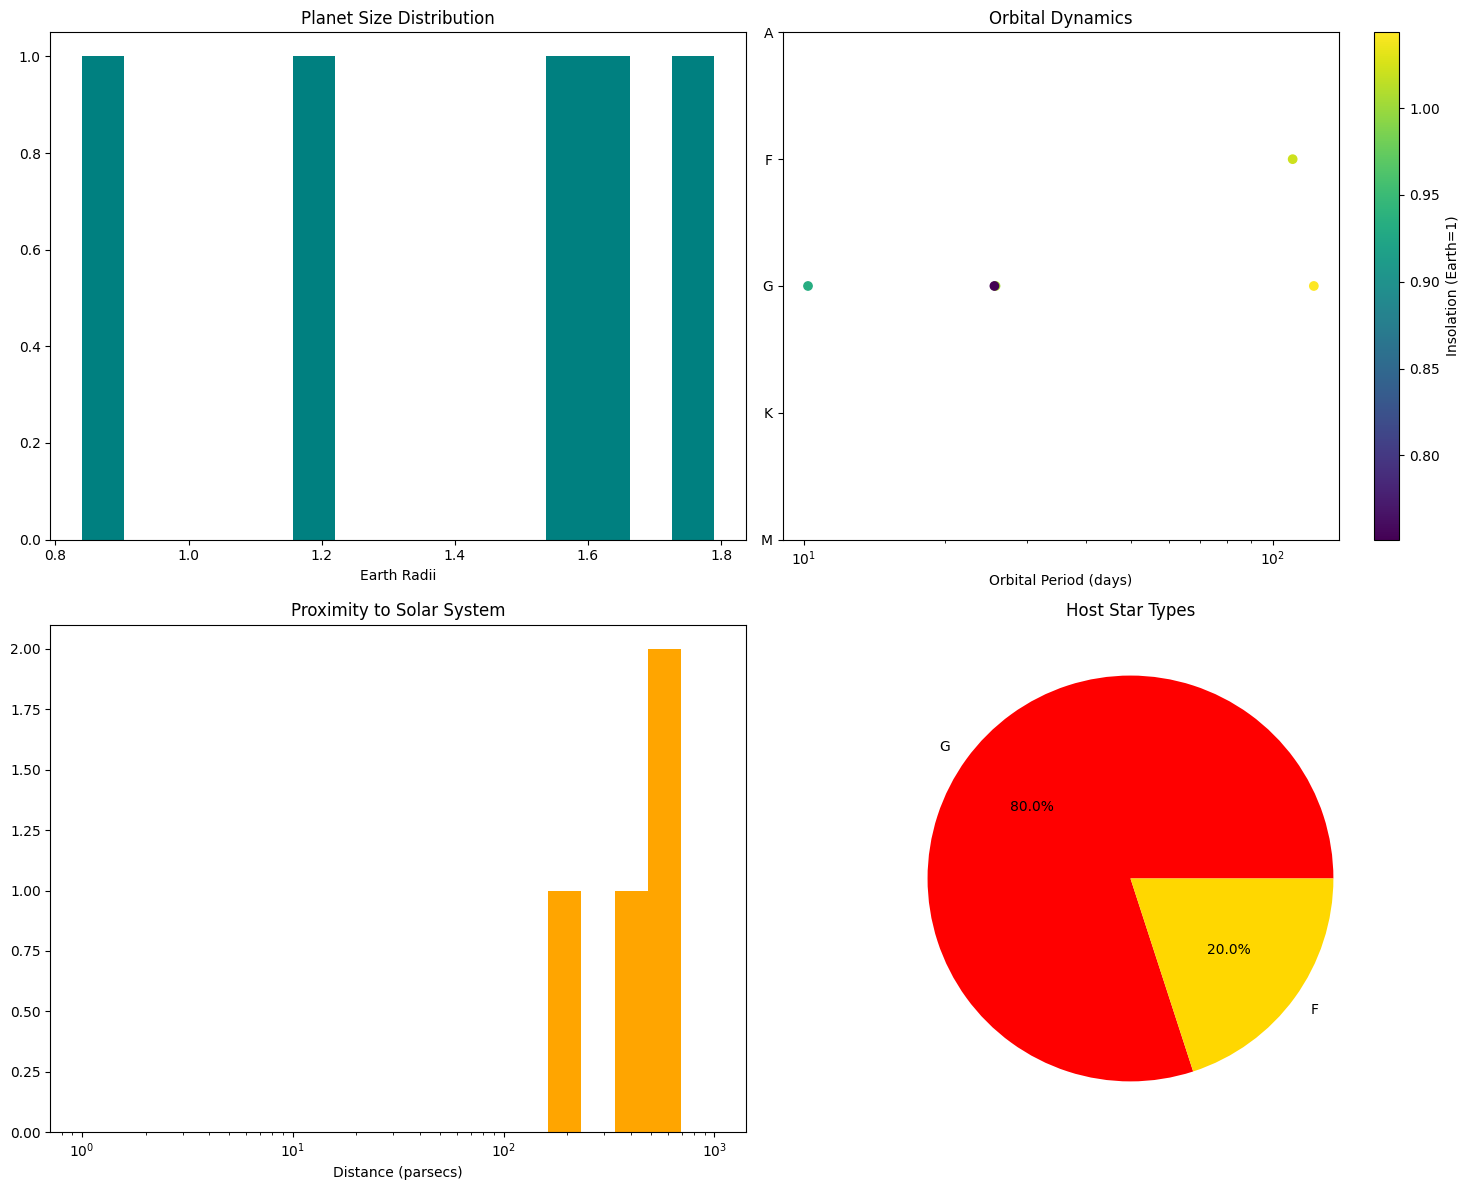

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import requests
import io

class ExoplanetFinder:
    def __init__(self):
        url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+pscomppars&format=csv"
        print("正在從 NASA Exoplanet Archive 取得最新資料...")
        response = requests.get(url)
        response.raise_for_status()
        self.df = pd.read_csv(io.StringIO(response.text))
        print("資料欄位：", list(self.df.columns))
        self._preprocess_data()

    def _preprocess_data(self):
        """資料清洗與單位轉換"""
        # pscomppars 本身只收錄已確認行星，無需再過濾
        # 去除關鍵欄位缺失
        self.df = self.df.dropna(subset=['pl_rade', 'st_lum', 'st_teff', 'pl_orbper', 'st_mass', 'sy_dist', 'pl_name'])

    def calculate_habitable_zone(self, star_lum, star_teff):
        if star_teff < 3700:
            inner = 0.75 * np.sqrt(star_lum)
            outer = 1.77 * np.sqrt(star_lum)
        else:
            inner = 0.95 * np.sqrt(star_lum)
            outer = 1.37 * np.sqrt(star_lum)
        return inner, outer

    def find_earth_like(self, max_radius=1.9, min_insolation=0.35, max_insolation=1.5):
        earth_candidates = []
        for _, row in self.df.iterrows():
            # 直接用 float 比較
            if (0.8 < row['pl_rade'] < max_radius and
                2500 < row['st_teff'] < 7200):

                # 計算宜居帶
                inner_hz, outer_hz = self.calculate_habitable_zone(row['st_lum'], row['st_teff'])

                # 計算軌道半徑 (Kepler's third law, AU)
                try:
                    # 轉換單位
                    P = row['pl_orbper'] * u.day
                    M = row['st_mass'] * u.M_sun
                    a = ((P**2 * const.G * M / (4 * np.pi**2))**(1/3)).to(u.AU).value
                except Exception:
                    continue

                # 接收輻射量 (相對於地球)
                insolation = row['st_lum'] / (a**2)

                if (inner_hz < a < outer_hz and min_insolation < insolation < max_insolation):
                    earth_candidates.append({
                        'name': row['pl_name'],
                        'radius': row['pl_rade'],
                        'orbital_period': row['pl_orbper'],
                        'insolation': insolation,
                        'star_type': self._classify_star(row['st_teff']),
                        'distance_pc': row['sy_dist']
                    })

        return pd.DataFrame(earth_candidates)

    def _classify_star(self, teff):
        t = teff
        if t < 3700: return 'M'
        elif 3700 <= t < 5200: return 'K'
        elif 5200 <= t < 6000: return 'G'
        elif 6000 <= t < 7500: return 'F'
        else: return 'A'

    def plot_results(self, candidates):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes[0,0].hist(candidates['radius'], bins=15, color='teal')
        axes[0,0].set_xlabel('Earth Radii')
        axes[0,0].set_title('Planet Size Distribution')

        sc = axes[0,1].scatter(candidates['orbital_period'],
                             candidates['star_type'].apply(lambda x: {'M':0, 'K':1, 'G':2, 'F':3, 'A':4}[x]),
                             c=candidates['insolation'], cmap='viridis')
        axes[0,1].set_xscale('log')
        axes[0,1].set_xlabel('Orbital Period (days)')
        axes[0,1].set_yticks([0,1,2,3,4], ['M','K','G','F','A'])
        axes[0,1].set_title('Orbital Dynamics')
        plt.colorbar(sc, label='Insolation (Earth=1)')

        axes[1,0].hist(candidates['distance_pc'], bins=np.logspace(0,3,20), color='orange')
        axes[1,0].set_xscale('log')
        axes[1,0].set_xlabel('Distance (parsecs)')
        axes[1,0].set_title('Proximity to Solar System')

        star_counts = candidates['star_type'].value_counts()
        axes[1,1].pie(star_counts, labels=star_counts.index, autopct='%1.1f%%',
                      colors=['red', 'gold', 'yellow', 'lightblue', 'blue'])
        axes[1,1].set_title('Host Star Types')

        plt.tight_layout()
        plt.show()

# 實戰應用 ====================================
finder = ExoplanetFinder()
candidates = finder.find_earth_like()

print(f"發現 {len(candidates)} 顆潛在類地行星")
print("最佳候選名單：")
print(candidates.sort_values('insolation', ascending=False).head())

finder.plot_results(candidates)